In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

from astrodet import astrodet as toolkit
toolkit.init()

toolKit Loaded!


### Set Paths Here

In [2]:

datasets_path = "/home/yufengl2/astro_rcnn/"
trainingset_name = "trainingset"
testset_name = "testset"
# a complete path will look like /home/yufengl2/astro_rcnn/traningset

### Load Custom Dataset

In [3]:
from detectron2.structures import BoxMode
import glob
from astropy.io import fits
import os

path = "./my_output/" + "astro_val" + "_coco_format.json"
lockpath = "./my_output/" + "astro_val" + "_coco_format.json.lock"
if os.path.exists(path):
    os.remove(path)
if os.path.exists(lockpath):
    os.remove(lockpath)
from detectron2.structures import BoxMode
import glob
from astropy.io import fits

def get_astro_dicts(img_dir):
    
    
    # It's weird to call this img_dir
    #set_dirs = glob.glob('%s/set_*' % img_dir)
    set_dirs = ['%s/set_%d' % (img_dir, i) for i in range(10)]
    
    dataset_dicts = []
    
    # Loop through each set
    for idx, set_dir in enumerate(set_dirs):
        record = {}
        
        mask_dir = os.path.join(img_dir, set_dir, "masks.fits")
        filename = os.path.join(img_dir, set_dir, "img")
        
        # Open each FITS image
        with fits.open(mask_dir, memmap=False, lazy_load_hdus=False) as hdul:
            sources = len(hdul)
            height, width = hdul[0].data.shape
            data = [hdu.data/np.max(hdu.data) for hdu in hdul]
            category_ids = [hdu.header["CLASS_ID"] for hdu in hdul]
            
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        
        # Mask value thresholds per category_id
        thresh = [0.005 if i == 1 else 0.08 for i in category_ids]
        
        # Generate segmentation masks
        for i in range(sources):
            image = data[i]
            mask = np.zeros([height, width], dtype=np.uint8)
            # Create mask from threshold
            mask[:,:][image > thresh[i]] = 1
            # Smooth mask
            mask[:,:] = cv2.GaussianBlur(mask[:,:], (9,9), 2)
            
            # https://github.com/facebookresearch/Detectron/issues/100
            mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                x,y,w,h = cv2.boundingRect(contour)
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            # No valid countors
            if len(segmentation) == 0:
                continue
            
            # Add to dict
            obj = {
                "bbox": [x, y, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i] - 1,
            }
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
         
    return dataset_dicts


DatasetCatalog.register("astro_train", lambda: get_astro_dicts(datasets_path + trainingset_name))
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy"])
astro_metadata = MetadataCatalog.get("astro_train")
DatasetCatalog.register("astro_val", lambda: get_astro_dicts(datasets_path + testset_name))
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy"])
astro_metadata_val = MetadataCatalog.get("astro_val")



### Visualize ground truth examples

In [4]:
from detectron2.data import build_detection_train_loader

def read_image(filename, normalize='zscore', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8):
    # Read image
    # TODO: Combine these files into one img_0, mask_0 ... in simulate.py
    g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
    elif normalize.lower() == 'zscore':
        Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        z = (z - np.nanmean(z) - m)/Isigma
        r = (r - np.nanmean(r) - m)/Isigma
        g = (g - np.nanmean(g) - m)/Isigma
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')

    max_RGB = np.nanpercentile([z, r, g], ceil_percentile) * 2
    # avoid saturation
    r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

    # Rescale to 0-255 for dtype=np.uint8
    max_dtype = np.iinfo(dtype).max
    r = r*max_dtype
    g = g*max_dtype
    z = z*max_dtype

    # 0-255 BGR image
    image[:,:,0] = g
    image[:,:,1] = r
    image[:,:,2] = z
    
    return image

100 instances
127 instances
125 instances


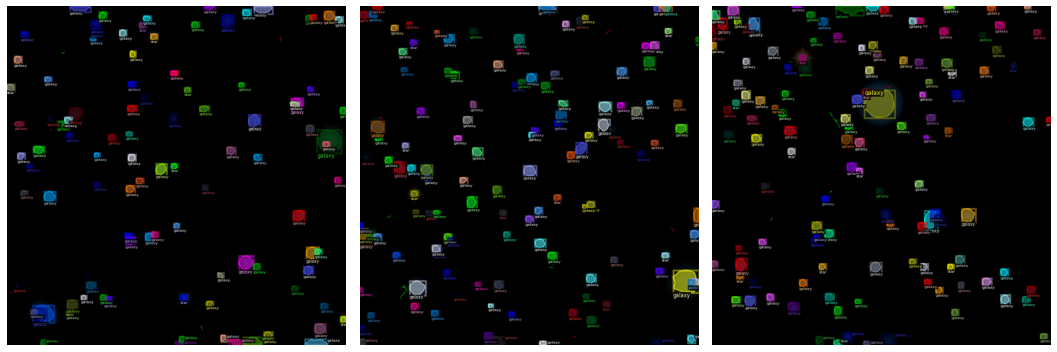

In [5]:
dataset_dicts = get_astro_dicts(datasets_path + trainingset_name)

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    img = read_image(d["file_name"], normalize="zscore")
    print(len(d['annotations']), "instances")
    visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

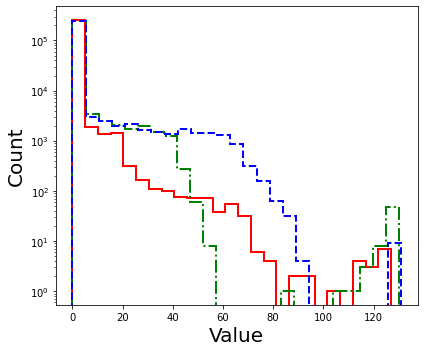

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
bins = 25
ax.hist(img[:,:,0].flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1);
ax.hist(img[:,:,1].flatten(), histtype="step", bins=bins, log=True, color="g", lw=2, linestyle='-.', zorder=2);
ax.hist(img[:,:,2].flatten(), histtype="step", bins=bins, log=True, color="b", lw=2, linestyle='dashed', zorder=3);
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
fig.tight_layout()

### Visualize Augmented Data

/home/yufengl2/astrodet_oct7_keepthis/astrodet/astrodet/astrodet.py:620: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/apps/anaconda3/envs/opence-v.1.1.1/conda-bld/pytorch-base_1611680481078/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  image = torch.from_numpy(auginput.image.transpose(2, 0, 1))


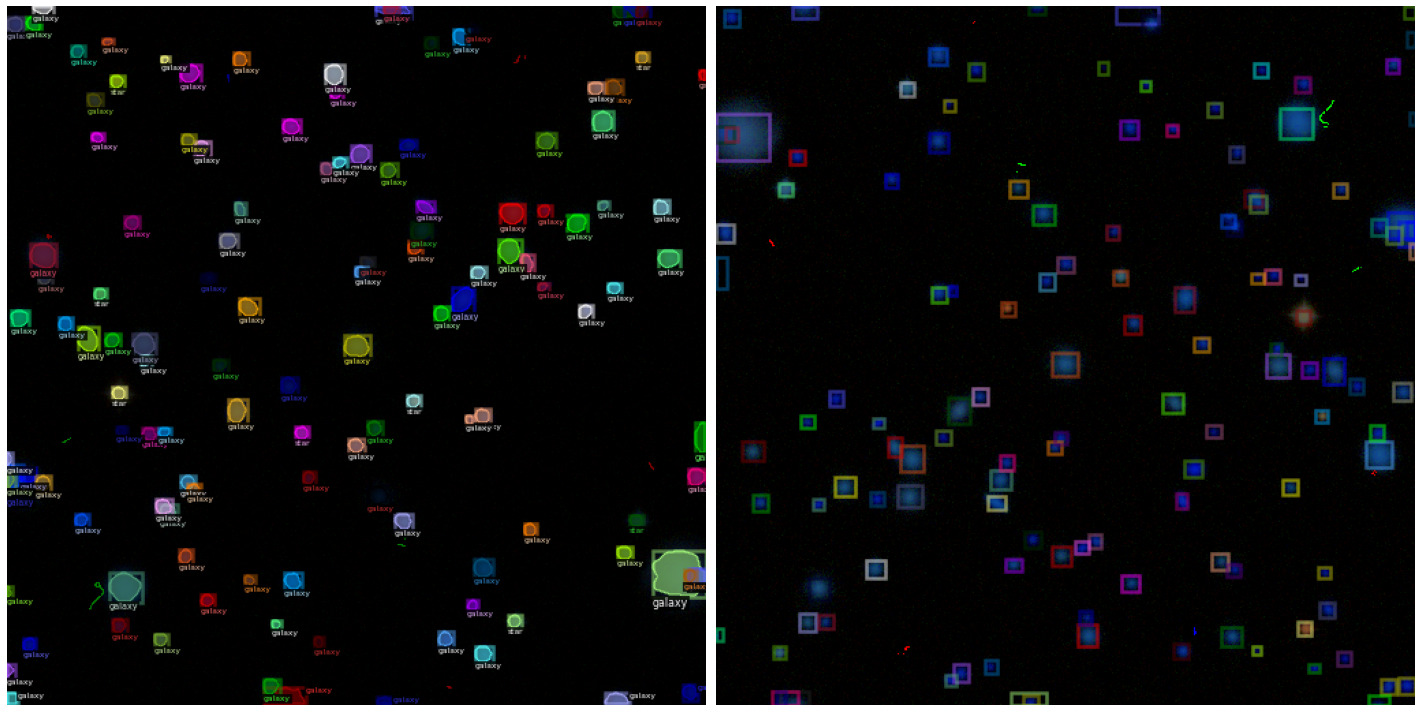

In [7]:
dataset_dicts = get_astro_dicts(datasets_path + trainingset_name)
fig, axs = plt.subplots(1,2,figsize=(10*2, 10))

dictionary = iter(dataset_dicts)
d = next(dictionary)
img = read_image(d["file_name"], normalize="zscore")
visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
out = visualizer.draw_dataset_dict(d)
axs[0].imshow(out.get_image())
axs[0].axis('off')
fig.tight_layout()
fig.show()

aug_data = toolkit.train_mapper(d)
img_aug = aug_data["image"]
img_reshape = torch.zeros((512,512,3))
for i in range(3):
    img_reshape[:,:,i]= img_aug[i,:,:]
visualizer = Visualizer(img_reshape, metadata=astro_metadata, scale=1)
out = visualizer.overlay_instances(boxes = aug_data["instances"].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis('off')
fig.tight_layout()
fig.show()

### Prepare For Training

Default: Training starts with weights from model zoo
Alternative: Training starts with a local model

In [8]:
use_model_from_zoo = False

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_train") # Register Metadata
cfg.DATASETS.TEST = ("astro_val") # Register Metadata
cfg.DATALOADER.NUM_WORKERS = 2
if use_model_from_zoo:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")  # Let training initialize from model zoo
else:
    cfg.MODEL.WEIGHTS = './my_output/model_temp.pth'  #Let training initialize from a local model
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR#start from 0.005
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.MAX_ITER = 100    #for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = './my_output/'
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
saveHook = toolkit.SaveHook()
saveHook.set_output_name("model_temp")
hookList = [saveHook]



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=toolkit.train_mapper)
print(type(optimizer))

[11/08 13:47:13 d2.data.build]: Removed 0 images with no usable annotations. 10 images left.
[11/08 13:47:13 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    star    | 138          |   galaxy   | 1185         |
|            |              |            |              |
|   total    | 1323         |            |              |
[11/08 13:47:13 d2.data.build]: Using training sampler TrainingSampler
[11/08 13:47:13 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[11/08 13:47:13 d2.data.common]: Serialized dataset takes 0.16 MiB
<class 'torch.optim.sgd.SGD'>


In [9]:
trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(1) # print loss every 25 iterations
trainer.train(0,2) #100 iterations gives a loss roughly at 1.1



[11/08 13:47:13 d2.engine.train_loop]: Starting training from iteration 0


/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/apps/anaconda3/envs/opence-v.1.1.1/conda-bld/pytorch-base_1611680481078/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


Iteration:  1  time:  1.778826117515564e-07  loss:  tensor(0.4577, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  2  time:  1.5739351511001587e-07  loss:  tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


### Plot The Loss

[]

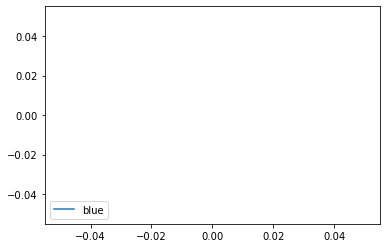

In [10]:
import matplotlib.pyplot as plt
import numpy as np
lossList = trainer.lossList #extract the loss
plt.plot(lossList)
plt.legend(['blue'], loc = 'lower left')
lossList[-10:] # print last 10 loss values

In [10]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output --host localhost

Launching TensorBoard...

KeyboardInterrupt: 

### Inference

In [10]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_temp.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

total instances: 143
detected instances: 115
total instances: 164
detected instances: 129
total instances: 137
detected instances: 115


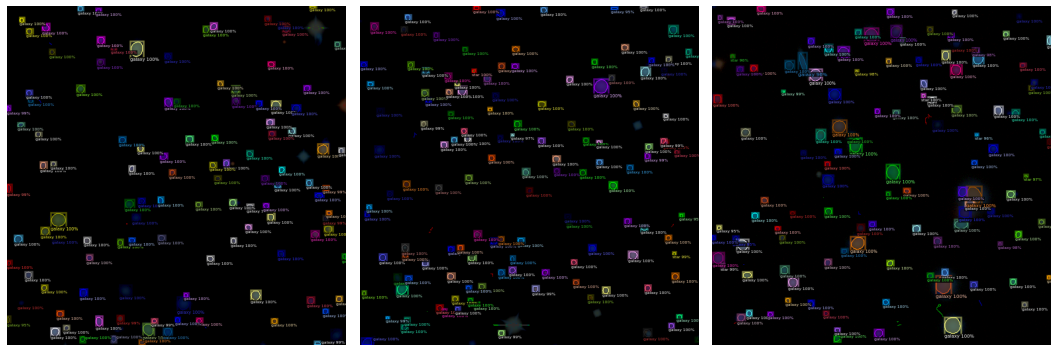

In [11]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_astro_dicts(datasets_path + testset_name) # Replace this with the validation dataset

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    print('total instances:', len(d['annotations']))
    im = read_image(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print('detected instances:',len(outputs['instances'].pred_boxes))
    v = Visualizer(im,
                   metadata=astro_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

### Evaluate

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = toolkit.COCOEvaluatorRecall("astro_val", cfg, False, output_dir="./my_output/") # Should be astro_val
dataset_dicts = get_astro_dicts(datasets_path + testset_name)
val_loader = build_detection_test_loader(dataset_dicts, mapper=toolkit.test_mapper)
results = inference_on_dataset(model, val_loader, evaluator) #yufeng 6/22  changed from trainer.model to model
#print(results)

WARNING [11/08 13:47:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/08 13:47:59 d2.evaluation.coco_evaluation]: 'astro_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[11/08 13:47:59 d2.data.datasets.coco]: Converting annotations of dataset 'astro_val' to COCO format ...)
[11/08 13:48:06 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/08 13:48:07 d2.data.datasets.coco]: Conversion finished, #images: 10, #annotations: 1444
[11/08 13:48:07 d2.data.datasets.coco]: Caching COCO format annotations at './my_output/astro_val_coco_format.json' ...
[11/08 13:48:14 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[11/08 13:48:15 d2.data.common]: Serialized dataset takes 0.17 MiB
[11/08 13:48:15 d2.evaluation.evaluator]: Start inference on 10 images
[11/08 13:48:18 d2.evaluation

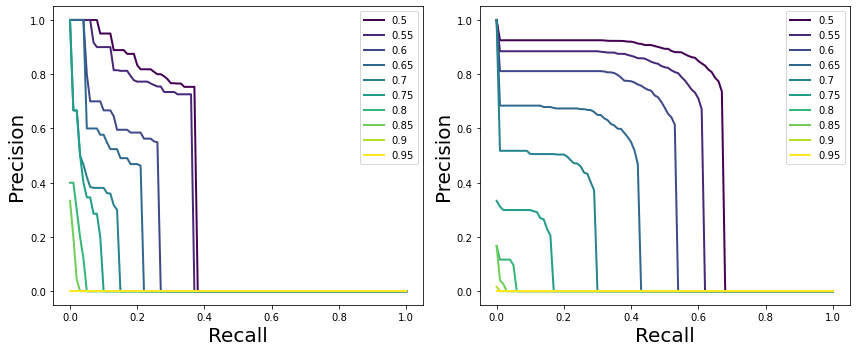

In [13]:
# Now get the precision
# precision has dims (iou, recall, cls, area range, max dets)
results_per_category = results['segm']['results_per_category']
#for ca in 
precision_star = results_per_category[0]
precision_galaxy = results_per_category[1]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))
#note: maxdet set to 2
# Plot precision recall
for j, precision_class in enumerate([precision_star, precision_galaxy]):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        # What are the IoU levels?
        p = precision_class[i, :, j, 0, -1]
        r = np.linspace(0, 1, precision_shape[1]) # i think
        mask = (p >-1)
        #redundant because p always>-1
        p = p[mask]
        r = r[mask]
        # Plot
        iou = np.around(ious[i], 2)
        #axs[j].plot(r, p, label=f'{iou}', color=colors[i],lw=2) # use a viridis color scheme
        axs[j].plot(r, p, label=f'{iou}', color=colors[i],lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].legend(fontsize=10)
        
fig.tight_layout()